In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from nfmd.NFMD import NFMD

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

In [2]:
def oscillator(t, y, xi, w_0, f):
    """Damped harmonic oscillator

    Keyword arguments:
    t -- time, independent variable
    y -- oscillator amplitude, dependent variable
    xi -- damping coefficient parameter
    w_0 -- resonant frequency
    f -- forcing function f(x)
    """
    y_t = y[1]
    y_tt = f(t) - (2*xi*w0)*y[1] - (w_0**2)*y[0]
    return [y_t, y_tt]


In [3]:
fs = 10e3
t_min=0
t_max = 10
n = int(t_max*fs)

# Time vector
t = np.linspace(int(t_min*fs), int(t_max*fs), n)
t /= fs

# Defined values
w0 = 50
k = 0.05
Q = 50
w_drive = 49.5

In [4]:
# Calculated values
w0 *= 2*np.pi
w_drive *= 2*np.pi
m = k/w0**2
xi = 1/(2*Q)
c = 2*xi*np.sqrt(m*k)

In [5]:
# Sort out the ICs
amp = 1e-1

delta = np.abs(np.arctan(np.divide(2 * (w_drive) * xi,
                                   (w0) ** 2 - (w_drive)** 2)))

# Set the initial conditions at t=0.
z0 = amp * np.sin(-delta)
v0 = amp * (w_drive) * np.cos(-delta)

init_vals = np.array([z0, v0])

In [6]:
init_vals, delta

(array([-3.16708751e-04,  3.11016113e+01]), 0.003167092800977607)

In [7]:
# Driving force
F_0 = 0.1
f_drive = lambda x: F_0/m*np.sin(w_drive*x)

# Perturbation Force
t_p = 5
alpha = 1
tau = 0.5
f_p = lambda x: np.heaviside(x-t_p, 0)*alpha/m*(1-np.exp(-(x-t_p)/tau))

f = lambda x: f_drive(x) + f_p(x)

In [8]:
%%time

# Set the ODE function
ode_func = lambda t, y: oscillator(t, y, xi, w0, f)

# Solve it
sol = solve_ivp(ode_func,
                [t_min, t_max],
                init_vals,
                t_eval=t,
                method='RK45',
                rtol=1e-9,
                atol=1e-10)


Wall time: 10.4 s


In [9]:
# Set the ODE function
ode_func = lambda t, y: oscillator(t, y, xi, w0, f_p)

# Solve it
sol_p = solve_ivp(ode_func,
                  [t_min, t_max],
                  init_vals,
                  t_eval=t,
                  method='RK45',
                  rtol=1e-9,
                  atol=1e-10)

In [10]:
# Extract the solution; trim off the transient response at beginning:
z = sol.y[0,:]
t_sol = sol.t
z_p = sol_p.y[0,:]
t_p = sol_p.t

# Trim off the beginning:
trim_sec = 4
z = z[int(fs*trim_sec):]
t_sol = t_sol[int(fs*trim_sec):]
z_p = z_p[int(fs*trim_sec):]
t_p = t_p[int(fs*trim_sec):]

In [13]:
%%time
###############
# Nonstationary Fourier Mode Decomposition
###############

nfmd = NFMD(z/np.std(z)+1,
            num_freqs=2,
            window_size=200,
            optimizer_opts={'lr': 4e-07},
            max_iters=100,
            target_loss=1e-3)

freqs, A, losses, indices = nfmd.decompose_signal(5000)

0/59801|5000/59801|10000/59801|15000/59801|20000/59801|25000/59801|30000/59801|35000/59801|40000/59801|45000/59801|50000/59801|55000/59801|Wall time: 28.8 s


In [14]:
n_freqs = nfmd.correct_frequencies(dt=1/fs)
n_amps = nfmd.compute_amps()
n_mean = nfmd.compute_mean()
n_mean = (n_mean-1)*np.std(z)
idcs = nfmd.mid_idcs

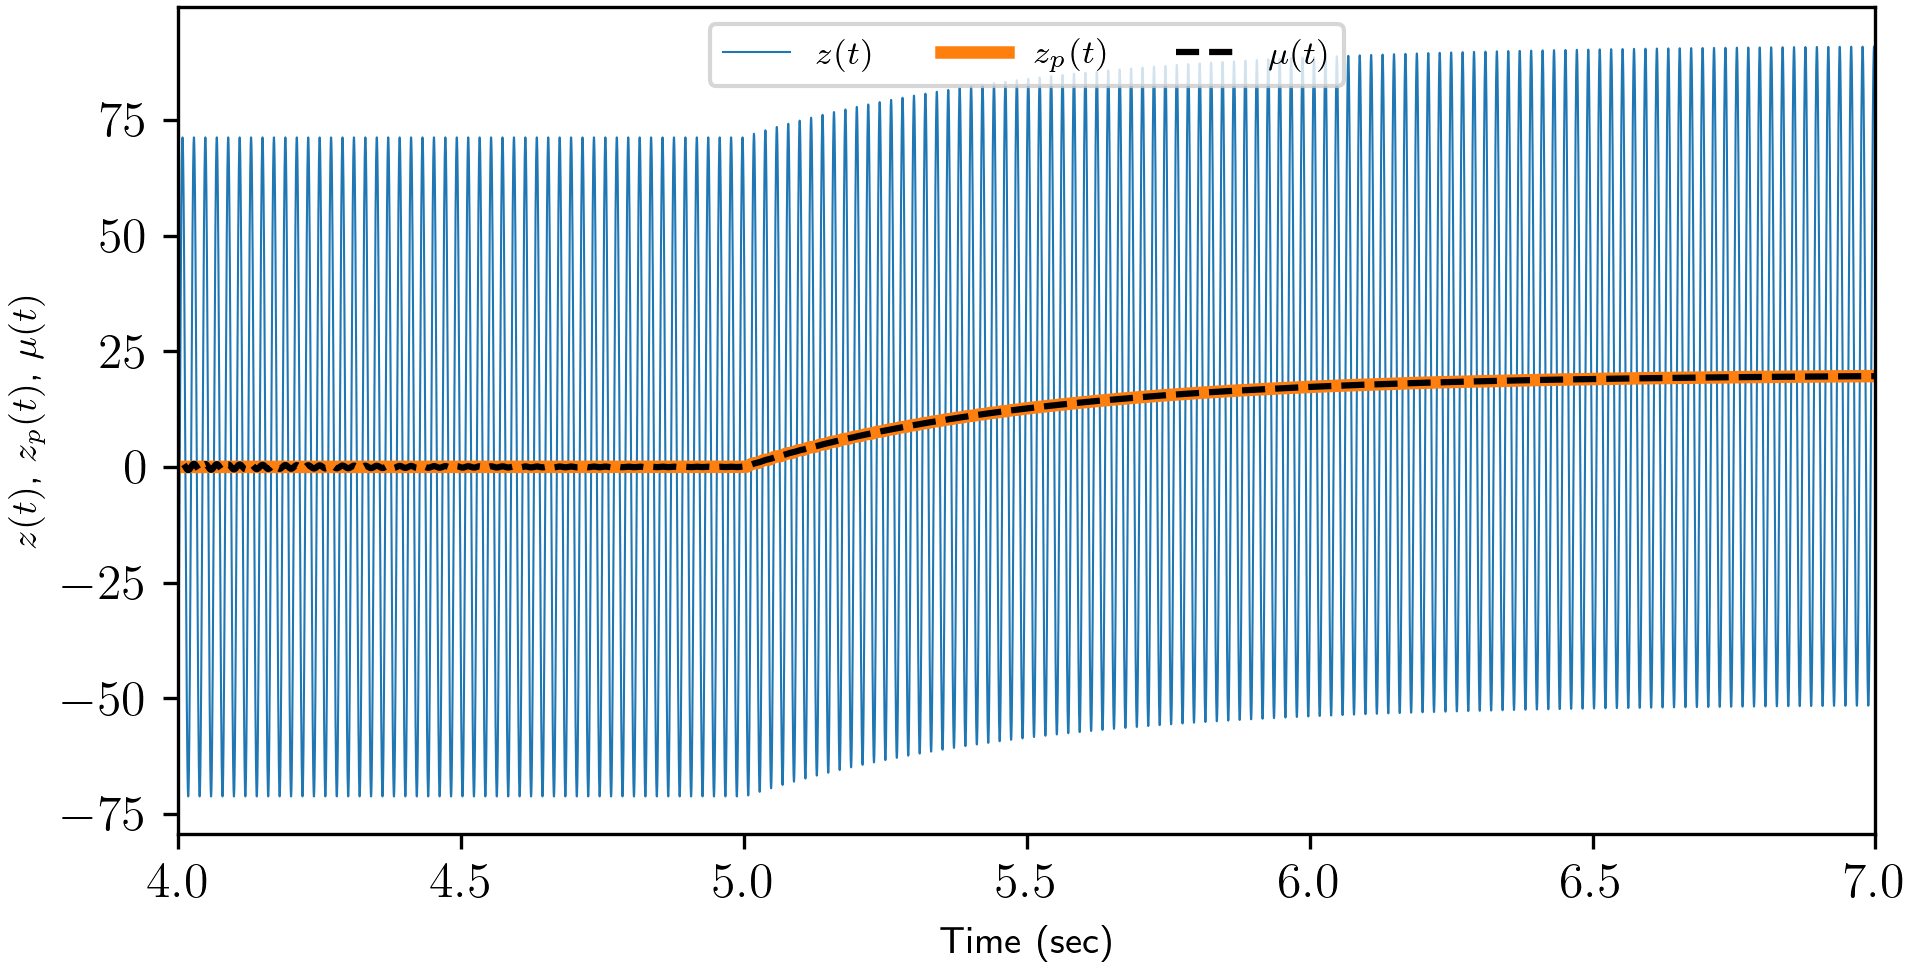

In [15]:
# Initialize figure:
fig3 = plt.figure()
gs = fig3.add_gridspec(1, 2)

##############################
## Top Row -- Driving Force ##
##############################
ax1 = fig3.add_subplot(gs[0, :])

ax1.plot(t_sol, z, label='$z(t)$', lw=0.5)
ax1.plot(t_p, z_p, lw=3, label='$z_p(t)$')
ax1.plot(t_sol[idcs], n_mean, '--k', label='$\mu(t)$')

################
## Formatting ##
################
# Put axis labels
ax1.set_ylabel('$z(t)$, $z_p(t)$, $\mu(t)$', fontsize=9)
ax1.set_xlabel('Time (sec)', fontsize=9)

# Set axis limits
ax1.set_xlim(4,7)
#ax1.set_ylim([-2.5e-3,5e-3])

ax1.legend(loc="upper center", ncol=3, fontsize=8)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.savefig("Fig9.png")

plt.show()